homework 12
===
due: June 22 2022

authors: pegler, prüwasser, scheftner

## Code from tutorial 13

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import optimize
warnings.filterwarnings('ignore')


def soft_max(vals, temp=1):   # default value for temperature is 1
    return (np.exp(vals/temp))/(np.sum(np.exp(vals/temp)))


def sim_exp(alpha, temp, n_trial, n_bandit, reward, p_reward):
    """Simulate choices and reward for give number of bandits"""
    
    vt = np.ones(n_bandit) 
    rewards = np.zeros(n_trial) 
    choices = np.intp(np.zeros(n_trial)) 

    for i in range(0, n_trial):
        choice_p = soft_max(vt, temp) 
        choice = np.random.multinomial(1, choice_p).argmax()
        actual_reward = np.random.binomial(1, p_reward[choice]) * reward
        vt[choice] = vt[choice] + alpha * (actual_reward - vt[choice])
        choices[i] = choice
        rewards[i] = actual_reward

    return choices, rewards, vt


def RL_likelihood(alpha, temp, choices, rewards):
    n_trial = len(choices)
    lh_tr = np.zeros(n_trial)
    vt = np.ones(n_bandit)  
    for i in range(n_trial):
        choice_p = soft_max(vt, temp)
        lh_tr[i] =  choice_p[choices[i]]
        vt[choices[i]] = vt[choices[i]] + alpha * (rewards[i] - vt[choices[i]])
    
    return lh_tr


def RL_fit_log_likelihood(pars, args):
    alpha, temp = pars[0], pars[1]
    choices, rewards = args[0], args[1]
    lh_tr = RL_likelihood(alpha, temp, choices, rewards)
    log_lh = -np.sum(np.log(lh_tr))
    
    return log_lh

## Part  1
 
Changing environments: reward probability in tutorial 13 is fixed, making the task of the 'experimental participant' relatively easy, since once you know the best option, you can just always choose it. 

### 1.1 Reward probabilities of the bandits change over time

Try to modify the code from tutorial 13, to make an experimental simulation where the rewards probabilities of the bandits change over time (but stay within the range 0-1). 

#### 1.1.1 Modified function for simulation with linearly changing probabilities for each bandit

In [2]:
def sim_exp_v(alpha, temp, n_trial, n_bandit, reward, seed=6):
    """Simulate choices and reward for given number of bandits
        with varying reward probabilities defined for each bandit in
        array p_rewards.
    """
    np.random.seed(seed)
    vt = np.ones((n_trial, n_bandit)) 
    p_rewards = np.zeros((n_bandit, n_trial))
    for bandit in range(n_bandit):
        p_rewards[bandit] = np.linspace(np.random.rand(), np.random.rand(), n_trial)
    vt_ = vt[0]
    rewards = np.zeros(n_trial) 
    choices = np.intp(np.zeros(n_trial)) 

    for i in range(0, n_trial):
        choice_p = soft_max(vt_, temp) 
        choice = np.random.multinomial(1, choice_p).argmax()
        actual_reward = np.random.binomial(1, p_rewards[choice][i]) * reward
        vt_[choice] = vt_[choice] + alpha * (actual_reward - vt_[choice])
        vt[i] = vt_
        choices[i] = choice
        rewards[i] = actual_reward

    return choices, rewards, vt, p_rewards

#### 1.1.2 Run simulation

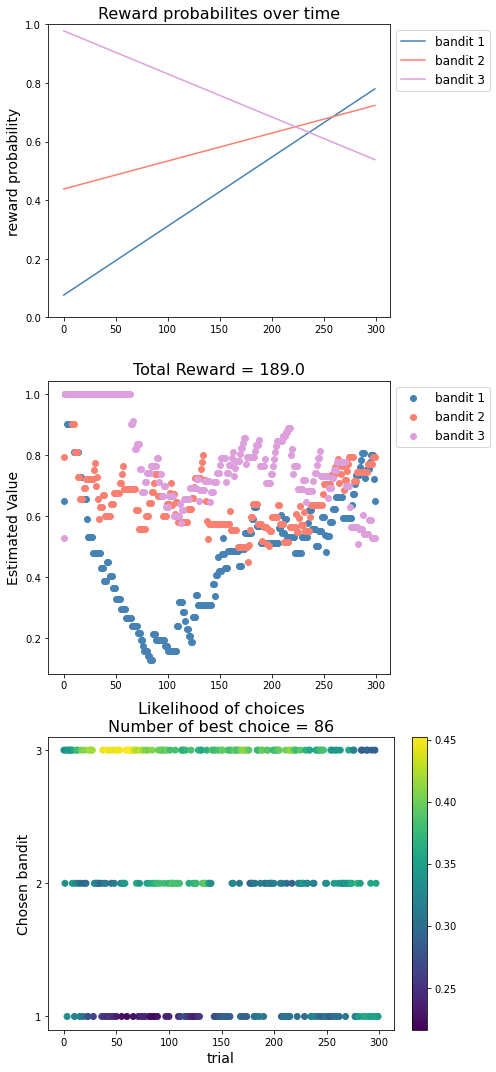

In [3]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 1
alpha = 0.1
seed = 7

choices, rewards, vt, p_rewards = sim_exp_v(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

colors = ['steelblue','salmon', 'plum', 'goldenrod', 'skyblue', 'firebrick', 'violet', 'grey']

fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# plot 1: probabilities
for bandit in range(n_bandit):
    axs[0].plot(range(n_trial), p_rewards[bandit], label=f"bandit {bandit+1}", color=colors[bandit])

axs[0].set_ylim((0, 1))
axs[0].set_ylabel("reward probability", fontsize=14)
axs[0].set_title("Reward probabilites over time", fontsize=16)
axs[0].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))

# plot 2: choices
for bandit in range(n_bandit):
    axs[1].scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"bandit {bandit+1}")

axs[1].set_ylabel('Estimated Value', fontsize=14)
axs[1].set_title('Total Reward = ' + str(np.sum(rewards)), fontsize=16)
axs[1].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))


# plot 3: likelihood
lh = RL_likelihood(alpha, temp, choices, rewards)
lh_plt = axs[2].scatter(range(len(choices)), choices, c=lh)
plt.colorbar(lh_plt, ax=axs[2], anchor=(2, 0), pad=-0.16)
axs[2].set_title('Likelihood of choices\nNumber of best choice = ' + str(np.sum(choices==0)), fontsize=16)
axs[2].set_xlabel("trial", fontsize=14)
axs[2].set_ylabel("Chosen bandit", fontsize=14)
axs[2].set_yticks(range(n_bandit), [b+1 for b in range(n_bandit)])
fig.tight_layout() 

### 1.2 Simulate 300 trials, where there is a change every 50 trials, ...
... when the reward probabilty values change (and also the identity of the best bandit)

#### 1.2.1 Modified function for simulation

In [4]:
def sim_exp_v2(alpha, temp, n_trial, n_bandit, reward, seed=6):
    """Simulate choices and reward for given number of bandits
        with varying reward probabilities every 50 trials (incl. change of best bandit)
        defined for each bandit in array p_rewards.
    """
    
    vt = np.ones((n_trial, n_bandit)) 
    rewards = np.zeros(n_trial) 
    choices = np.intp(np.zeros(n_trial))
    
    np.random.seed(seed)
    p_reward = np.random.rand(n_bandit)
    p_rewards = np.zeros((n_trial, n_bandit))
    best_bandit = p_reward.argmax()
    vt_ = vt[0]

    for i in range(0, n_trial):
        if i % 50 == 0:
            np.random.seed(seed+i)
            p_reward_ = list(np.random.rand(n_bandit))
            p_reward_.sort(reverse=True)
            # define new best bandit
            poss_new_bb = list(range(n_bandit))
            poss_new_bb.remove(best_bandit)
            best_bandit = np.random.choice(poss_new_bb)
            # change order so that another bandit is now best bandit
            p_reward = np.zeros(n_bandit)
            for bandit in range(n_bandit):
                if bandit==best_bandit:
                    p_reward[bandit] = p_reward_[0]

                else:
                    p_reward[bandit] = p_reward_.pop(np.random.choice(range(1, len(p_reward_))))
        p_rewards[i] = p_reward
        choice_p = soft_max(vt_, temp) 
        choice = np.random.multinomial(1, choice_p).argmax()
        actual_reward = np.random.binomial(1, p_reward[choice]) * reward
        vt_[choice] = vt_[choice] + alpha * (actual_reward - vt_[choice])
        vt[i] = vt_
        choices[i] = choice
        rewards[i] = actual_reward
        
    return choices, rewards, vt, p_rewards

#### 1.2.2 Run simulation

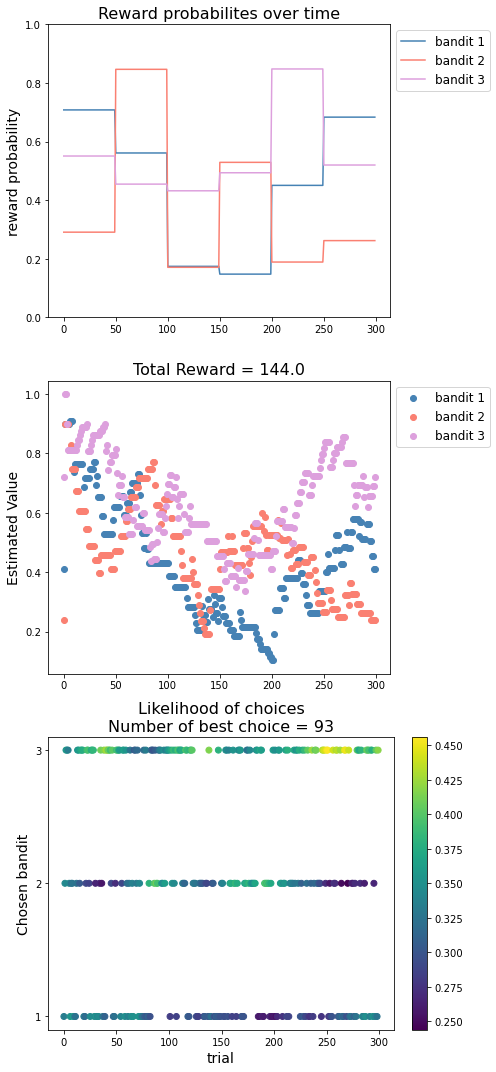

In [5]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 1
alpha = 0.1
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# plot 1: probabilities
for bandit in range(n_bandit):
    axs[0].plot(range(n_trial), p_rewards.T[bandit], label=f"bandit {bandit+1}", color=colors[bandit])

axs[0].set_ylim((0, 1))
axs[0].set_ylabel("reward probability", fontsize=14)
axs[0].set_title("Reward probabilites over time", fontsize=16)
axs[0].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))

# plot 2: choices
for bandit in range(n_bandit):
    axs[1].scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"bandit {bandit+1}")

axs[1].set_ylabel('Estimated Value', fontsize=14)
axs[1].set_title('Total Reward = ' + str(np.sum(rewards)), fontsize=16)
axs[1].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))


# plot 3: likelihood
lh = RL_likelihood(alpha, temp, choices, rewards)
lh_plt = axs[2].scatter(range(len(choices)), choices, c=lh)
plt.colorbar(lh_plt, ax=axs[2], anchor=(2, 0), pad=-0.16)
axs[2].set_title('Likelihood of choices\nNumber of best choice = ' + str(np.sum(choices==0)), fontsize=16)
axs[2].set_xlabel("trial", fontsize=14)
axs[2].set_ylabel("Chosen bandit", fontsize=14)
axs[2].set_yticks(range(n_bandit), [b+1 for b in range(n_bandit)])
fig.tight_layout() 

### 1.3 Explore different values of alpha and temperature ...
... in this experiment, and visualize your results (good values are the ones that lead to a high total reward).

Lower temperature $\to$ reward goes up

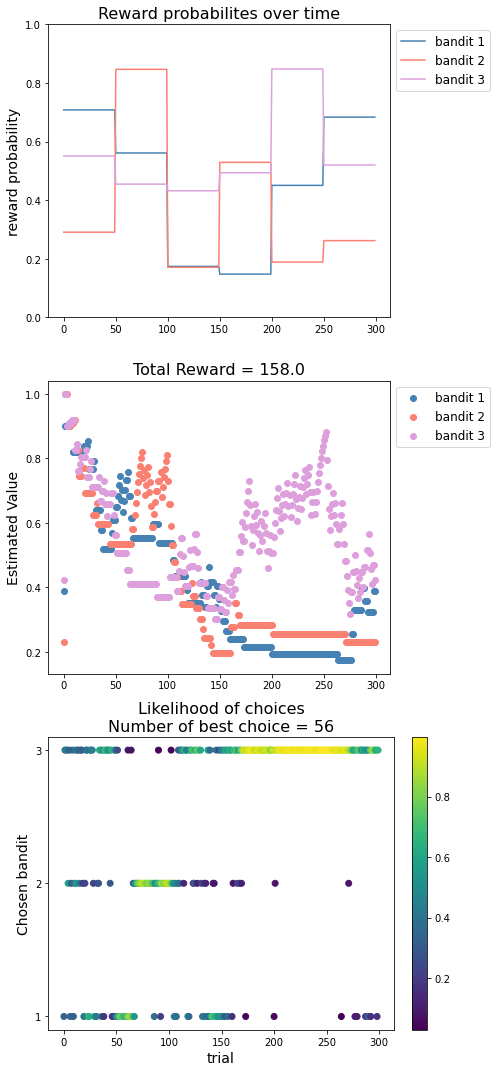

In [6]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 0.1
alpha = 0.1
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# plot 1: probabilities
for bandit in range(n_bandit):
    axs[0].plot(range(n_trial), p_rewards.T[bandit], label=f"bandit {bandit+1}", color=colors[bandit])

axs[0].set_ylim((0, 1))
axs[0].set_ylabel("reward probability", fontsize=14)
axs[0].set_title("Reward probabilites over time", fontsize=16)
axs[0].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))

# plot 2: choices
for bandit in range(n_bandit):
    axs[1].scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"bandit {bandit+1}")

axs[1].set_ylabel('Estimated Value', fontsize=14)
axs[1].set_title('Total Reward = ' + str(np.sum(rewards)), fontsize=16)
axs[1].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))


# plot 3: likelihood
lh = RL_likelihood(alpha, temp, choices, rewards)
lh_plt = axs[2].scatter(range(len(choices)), choices, c=lh)
plt.colorbar(lh_plt, ax=axs[2], anchor=(2, 0), pad=-0.16)
axs[2].set_title('Likelihood of choices\nNumber of best choice = ' + str(np.sum(choices==0)), fontsize=16)
axs[2].set_xlabel("trial", fontsize=14)
axs[2].set_ylabel("Chosen bandit", fontsize=14)
axs[2].set_yticks(range(n_bandit), [b+1 for b in range(n_bandit)])
fig.tight_layout() 

Higher alpha $\to$ reward goes up

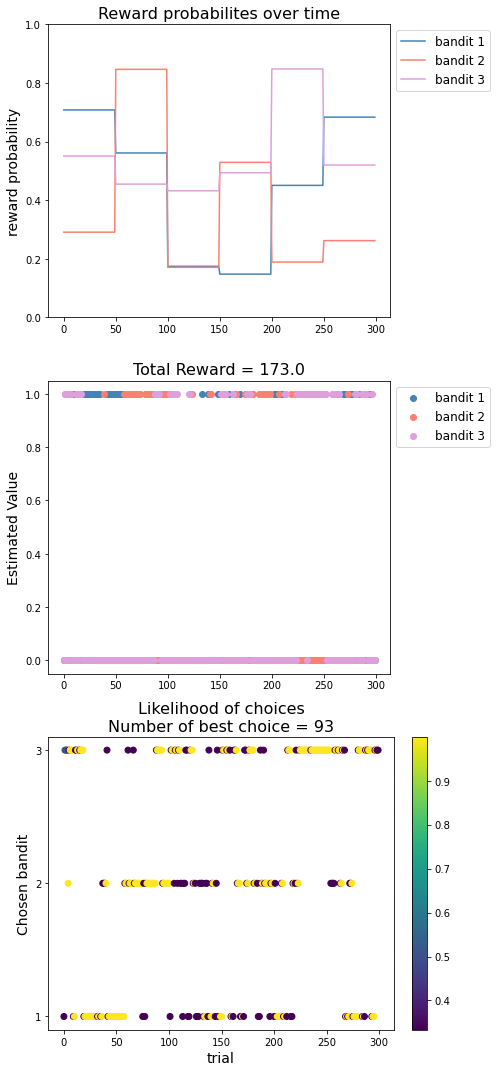

In [7]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 0.1
alpha = 1
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# plot 1: probabilities
for bandit in range(n_bandit):
    axs[0].plot(range(n_trial), p_rewards.T[bandit], label=f"bandit {bandit+1}", color=colors[bandit])

axs[0].set_ylim((0, 1))
axs[0].set_ylabel("reward probability", fontsize=14)
axs[0].set_title("Reward probabilites over time", fontsize=16)
axs[0].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))

# plot 2: choices
for bandit in range(n_bandit):
    axs[1].scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"bandit {bandit+1}")

axs[1].set_ylabel('Estimated Value', fontsize=14)
axs[1].set_title('Total Reward = ' + str(np.sum(rewards)), fontsize=16)
axs[1].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))


# plot 3: likelihood
lh = RL_likelihood(alpha, temp, choices, rewards)
lh_plt = axs[2].scatter(range(len(choices)), choices, c=lh)
plt.colorbar(lh_plt, ax=axs[2], anchor=(2, 0), pad=-0.16)
axs[2].set_title('Likelihood of choices\nNumber of best choice = ' + str(np.sum(choices==0)), fontsize=16)
axs[2].set_xlabel("trial", fontsize=14)
axs[2].set_ylabel("Chosen bandit", fontsize=14)
axs[2].set_yticks(range(n_bandit), [b+1 for b in range(n_bandit)])
fig.tight_layout() 

### 1.4 Visualize the outcome ...
...(including when the change in value occurs). As an inspiration, you could use the figure on the lecture slide 8. However that is for 1 bandit only.

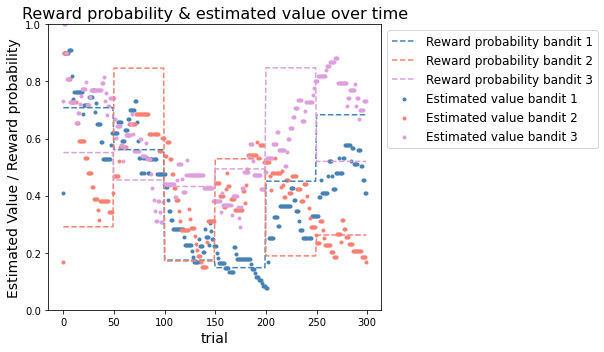

In [54]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 10
alpha = 0.1
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, ax = plt.subplots(1, 1, figsize=(8.5, 5))

# plot 1: probabilities
for bandit in range(n_bandit):
    ax.plot(range(n_trial), p_rewards.T[bandit], label=f"Reward probability bandit {bandit+1}", color=colors[bandit], lw=1.5, linestyle="--")


# plot 2: choices
for bandit in range(n_bandit):
    ax.scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"Estimated value bandit {bandit+1}", alpha=1, marker=".")

ax.set_ylabel('Estimated Value / Reward probability', fontsize=14)
ax.set_title("Reward probability & estimated value over time", fontsize=16)
ax.legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("trial", fontsize=14)
ax.set_ylim((0, 1))
fig.tight_layout() 

### 1.5 Make 3 figures, ...
... where you show how 3 different values of alpha (.01,.03,.1) affect the learning of the reward probability.
Which one seems the best in this changing environment?

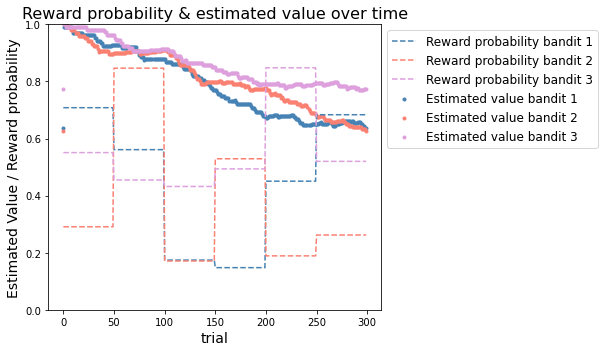

In [57]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 0.5
alpha = 0.01
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, ax = plt.subplots(1, 1, figsize=(8.5, 5))

# plot 1: probabilities
for bandit in range(n_bandit):
    ax.plot(range(n_trial), p_rewards.T[bandit], label=f"Reward probability bandit {bandit+1}", color=colors[bandit], lw=1.5, linestyle="--")


# plot 2: choices
for bandit in range(n_bandit):
    ax.scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"Estimated value bandit {bandit+1}", alpha=1, marker=".")

ax.set_ylabel('Estimated Value / Reward probability', fontsize=14)
ax.set_title("Reward probability & estimated value over time", fontsize=16)
ax.legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("trial", fontsize=14)
ax.set_ylim((0, 1))
fig.tight_layout() 

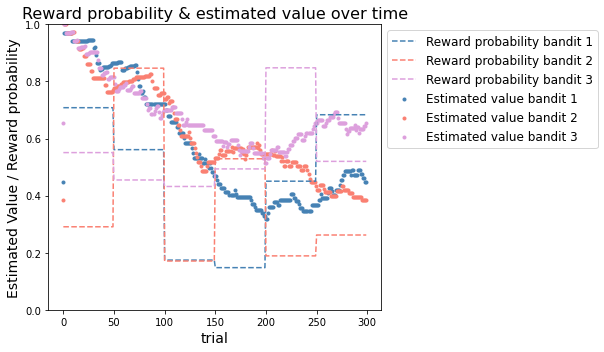

In [58]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 0.5
alpha = 0.03
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, ax = plt.subplots(1, 1, figsize=(8.5, 5))

# plot 1: probabilities
for bandit in range(n_bandit):
    ax.plot(range(n_trial), p_rewards.T[bandit], label=f"Reward probability bandit {bandit+1}", color=colors[bandit], lw=1.5, linestyle="--")


# plot 2: choices
for bandit in range(n_bandit):
    ax.scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"Estimated value bandit {bandit+1}", alpha=1, marker=".")

ax.set_ylabel('Estimated Value / Reward probability', fontsize=14)
ax.set_title("Reward probability & estimated value over time", fontsize=16)
ax.legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("trial", fontsize=14)
ax.set_ylim((0, 1))
fig.tight_layout() 

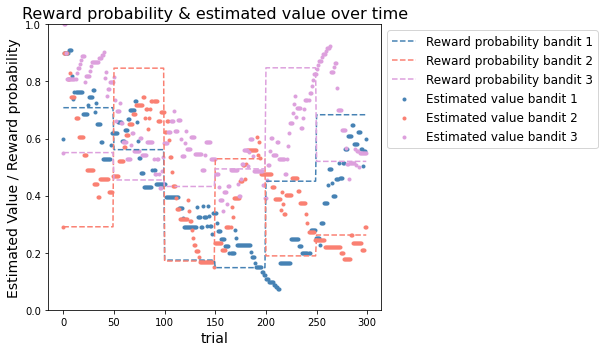

In [59]:
n_trial = 300
n_bandit = 3
reward = 1
temp = 0.5
alpha = 0.1
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, ax = plt.subplots(1, 1, figsize=(8.5, 5))

# plot 1: probabilities
for bandit in range(n_bandit):
    ax.plot(range(n_trial), p_rewards.T[bandit], label=f"Reward probability bandit {bandit+1}", color=colors[bandit], lw=1.5, linestyle="--")


# plot 2: choices
for bandit in range(n_bandit):
    ax.scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"Estimated value bandit {bandit+1}", alpha=1, marker=".")

ax.set_ylabel('Estimated Value / Reward probability', fontsize=14)
ax.set_title("Reward probability & estimated value over time", fontsize=16)
ax.legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("trial", fontsize=14)
ax.set_ylim((0, 1))
fig.tight_layout() 

<div class="alert-success alert" role="alert">Learning rate of 0.1 works best in our case.</div>

## Part 2 
modify the in-class code that instead of a 3 bandit tasks, it is a real N-bandit task, where the choice is simulated among N-bandits, and the reward probabilty is random on the range 0-1 for each bandit.

<div class="alert-info alert" role="alert">Our function from before is already prepared to take in an n_bandit variable.</div>

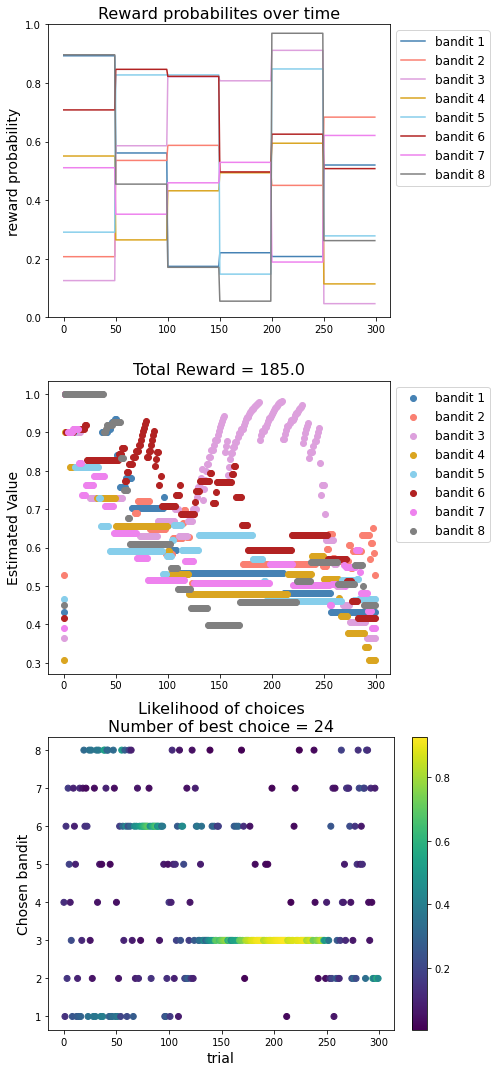

In [114]:
n_trial = 300
n_bandit = 8
reward = 1
temp = 0.1
alpha = 0.1
seed = 3

choices, rewards, vt, p_rewards = sim_exp_v2(alpha=alpha, temp=temp, n_trial=n_trial, n_bandit=n_bandit, reward=reward, seed=seed)

fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# plot 1: probabilities
for bandit in range(n_bandit):
    axs[0].plot(range(n_trial), p_rewards.T[bandit], label=f"bandit {bandit+1}", color=colors[bandit])

axs[0].set_ylim((0, 1))
axs[0].set_ylabel("reward probability", fontsize=14)
axs[0].set_title("Reward probabilites over time", fontsize=16)
axs[0].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))

# plot 2: choices
for bandit in range(n_bandit):
    axs[1].scatter(range(n_trial), vt[:, bandit], color=colors[bandit], label=f"bandit {bandit+1}")

axs[1].set_ylabel('Estimated Value', fontsize=14)
axs[1].set_title('Total Reward = ' + str(np.sum(rewards)), fontsize=16)
axs[1].legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))


# plot 3: likelihood
lh = RL_likelihood(alpha, temp, choices, rewards)
lh_plt = axs[2].scatter(range(len(choices)), choices, c=lh)
plt.colorbar(lh_plt, ax=axs[2], anchor=(2, 0), pad=-0.16)
axs[2].set_title('Likelihood of choices\nNumber of best choice = ' + str(np.sum(choices==0)), fontsize=16)
axs[2].set_xlabel("trial", fontsize=14)
axs[2].set_ylabel("Chosen bandit", fontsize=14)
axs[2].set_yticks(range(n_bandit), [b+1 for b in range(n_bandit)])
fig.tight_layout() 